In [163]:
from PIL import Image
from ipywidgets import interact,interactive,interact_manual
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import math



In [164]:
def showLinear(data, threshold=50):
    plt.figure(figsize=(10,6))
    
    # 假設 data 是 list of lists，每個子列表是一條曲線
    for i, y in enumerate(data):
        x = range(len(y))
        plt.plot(x, y, label=f"Curve {i+1}")  # 自動加 label

    # 只有當至少有一個 label 存在時才呼叫 legend
    handles, labels = plt.gca().get_legend_handles_labels()
    if labels:
        plt.legend(loc="best", fontsize=20)

    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title("Linear Plot")
    plt.show()


左圖 : 彩色照片(橫) 1 pixel > RGB 三個值 : [164 149 130]
Size : 2364750  = 750 x 1051 x 3 

中圖 : 灰階照片 1 pixel > 灰階值 : 151
Size : 788250  = 750 x 1051 

右圖 : 彩色照片(直) 1 pixel > RGB 三個值 : [ 98 101  80]
Size : 1592976  = 862 x 616 x 3 



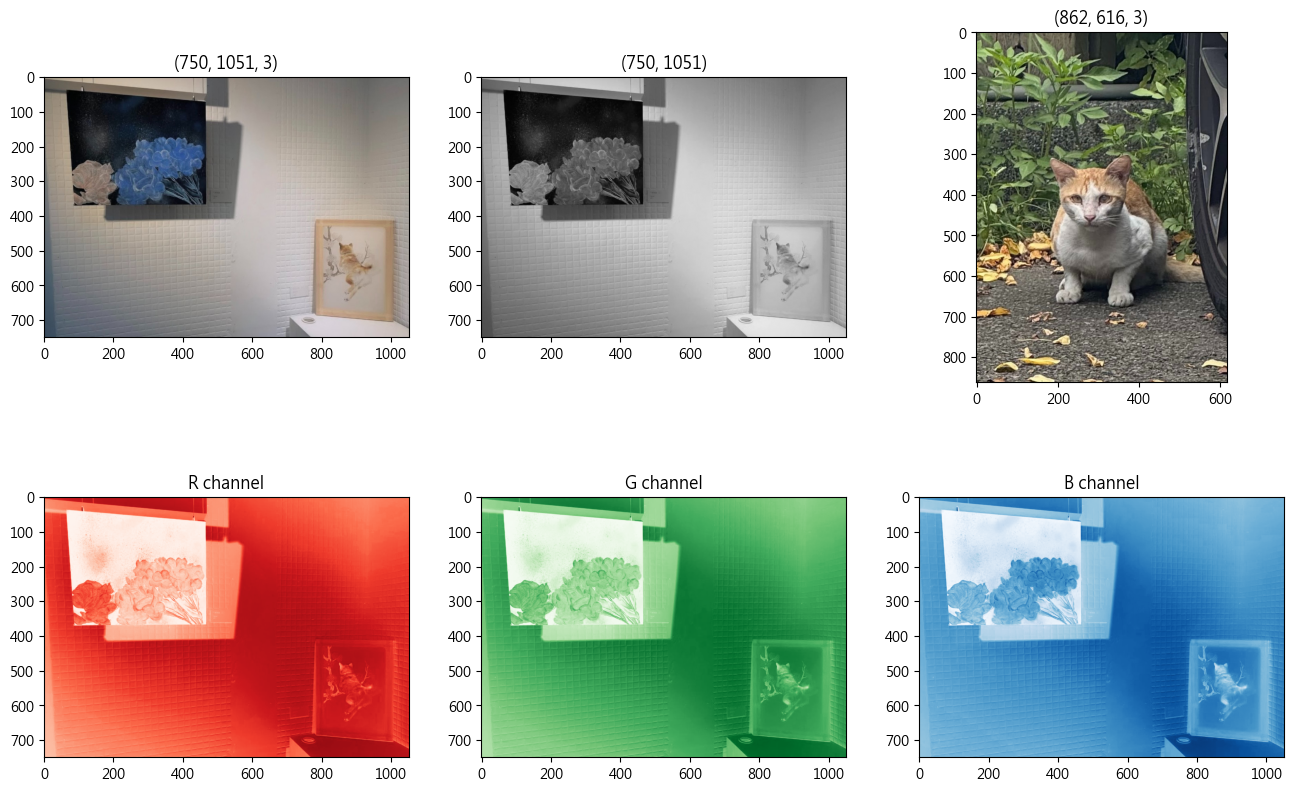

In [165]:
# 讀出一張RGB圖片(橫)

img_painting = Image.open("./images/svd/painting.jpg", "r")

# 將RGB圖片轉為矩陣表示

painting = np.array(img_painting)

# 將RGB圖片轉為灰階圖片

img_to_gray = Image.open("./images/svd/painting.jpg").convert("L")
painting_gray = np.array(img_to_gray)
img_gray = Image.fromarray(painting_gray).save("./images/svd/painting_gr.jpg")

# 讀出一張RGB圖片(直)

img_cat_ver = Image.open("./images/svd/schoolCat.jpg", "r")
cat_ver = np.array(img_cat_ver)

# 繪圖

plt.figure(figsize=(16 ,10))

plt.subplot(2,3,1)
plt.title(painting.shape)
plt.imshow(painting)

plt.subplot(2,3,2)
plt.title(painting_gray.shape)
plt.imshow(painting_gray, cmap="gray")

plt.subplot(2,3,3)
plt.title(cat_ver.shape)
plt.imshow(cat_ver)

plt.subplot(2,3,4)
plt.title("R channel")
plt.imshow(painting[:,:,0], cmap="Reds")

plt.subplot(2,3,5)
plt.title("G channel")
plt.imshow(painting[:,:,1], cmap="Greens")

plt.subplot(2,3,6)
plt.title("B channel")
plt.imshow(painting[:,:,2], cmap="Blues")

# 顯示資訊
print("左圖 : 彩色照片(橫) 1 pixel > RGB 三個值 :", painting[0][0])
print("Size :", painting.size, " =", painting.shape[0], "x", painting.shape[1], "x", painting.shape[2], "\n")

print("中圖 : 灰階照片 1 pixel > 灰階值 :", painting_gray[0][0])
print("Size :", painting_gray.size, " =", painting_gray.shape[0], "x", painting_gray.shape[1], "\n")

print("右圖 : 彩色照片(直) 1 pixel > RGB 三個值 :", cat_ver[0][0])
print("Size :", cat_ver.size, " =", cat_ver.shape[0], "x", cat_ver.shape[1], "x", cat_ver.shape[2], "\n")

In [166]:
# 2-norm

def norm2 (a, ak):
    return np.linalg.norm(a-ak, 2)

In [167]:
# mse 均方誤差

def mse (a, ak):
    m = np.mean((a/1.0 - ak/1.0) ** 2)
    return m

In [168]:

# Singular Value Decomposition (SVD)

def svd_restore(image, k, rgb):

    # 對圖形矩陣做 SVD 分解 : u > mxm, sigma > m, v > mxn
    u, sigma, v = np.linalg.svd(image, full_matrices=False)

    # 避免 K 值超出 sigma > m 長度
    k = min(len(sigma)-1, k) 

    # 依照 k 值，得到新的圖形矩陣
    Ak  = np.dot(u[:,:k], np.dot(np.diag(sigma[:k]), v[:k,:]))

    # 計算原圖矩陣與新圖矩陣的 2-norm
    norm = norm2(image, Ak)

    # 計算原圖矩陣與新圖矩陣的 mse
    m = mse(image, Ak)

    # value 小於 0 > 改 0
    Ak[Ak < 0] = 0     
    
    # value 大於 255 > 改 255
    Ak[Ak > 255] = 255

    # 算出來為float，四捨五入取整數，轉型為圖片所需的 uint8
    Ak = np.rint(Ak).astype('uint8')

    return Ak, sigma, norm, sigma[k], m

In [169]:
# PSNR - 峰值訊噪比

def psnr(originalImg, sampleImg):

   mse = np.mean((originalImg/1.0 - sampleImg/1.0) ** 2 )
   
   if mse < 1.0e-10:
      return 100
   
   return 10 * math.log10(255.0**2/mse)

In [170]:
# CR - compression Ratio 資料壓縮比

def cr(originalSize, sampleSize):
   return (originalSize/sampleSize)

# ss - save space 節省空間比率

def ss(originalSize, sampleSize):
   return (1-sampleSize/originalSize)*100

In [171]:
# 詳細資料圖表

def showTable(rangeArrK, info, fileName):

   table = np.zeros((15, 9))

   table[:,0] = rangeArrK.T
   table[:,1] = info[:,0]
   table[:,2] = info[:,1]
   table[:,7] = info[:,2]

   originalImage = cv2.imread("./images/svd/" + fileName + ".jpg")
   originalImageSize = round(os.stat("./images/svd/" + fileName + ".jpg").st_size/1024, 2)

   i = 0

   for item in rangeArrK:
      table[i,3] = originalImageSize
      table[i,4] = round(os.stat("./images/svd/svd_" + fileName + "_" + str(item) + ".jpg").st_size/1024, 2)
      svdImg = cv2.imread("./images/svd/svd_" + fileName + "_" + str(item) + ".jpg")
      table[i,5] = cr(originalImageSize, table[i,4])
      table[i,6] = ss(originalImageSize, table[i,4])
      table[i,8] = psnr(originalImage, svdImg)
      i += 1

   return table

# k值-正相關 SS MSE-負相關 SIZE PSNR

def showLinear(table, resize):
   plt.figure(figsize=(24,8),dpi=50,linewidth = 2)
   plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
   plt.xticks(fontsize=20)
   plt.yticks(fontsize=20)
   plt.xlabel("k值", fontsize=30, labelpad = 15)
    
   plt.subplot(1,2,1)
   plt.plot(table[:,0], table[:,6],'s-',color = 'red', label="SS")
   plt.plot(table[:,0], table[:,7]/resize,'s-',color = 'skyblue', label="MSE/"+str(resize))
   plt.legend(loc = "best", fontsize=20)
    
   plt.subplot(1,2,2)
   plt.plot(table[:,0], table[:,4],'s-',color = 'green', label="SIZE")
   plt.plot(table[:,0], table[:,8],'s-',color = 'blue', label="PSNR")
   plt.legend(loc = "best", fontsize=20)
   plt.show()

# 可動態調整k值-灰階

def compress_show_gray_images(k):
    image = painting_gray
    original_shape = image.shape
    reconst_img, sigma, norm, sigmak1, m = svd_restore(image, k, "灰階")
    fig,axes = plt.subplots(1,2,figsize=(8,5))
    axes[0].plot(sigma)
    axes[0].set_xlabel("k值", fontsize=12, labelpad = 15)
    axes[0].set_ylabel("sigma值", fontsize=12, labelpad = 20)
    axes[1].imshow(reconst_img,cmap='gray')
    axes[1].axis('off')
    fig.tight_layout()

# 可動態調整k值-彩色-resharp

def compress_show_color_images_reshape(k):
    image = painting
    original_shape = image.shape
    image_reshaped = image.reshape((original_shape[0],original_shape[1]*3))
    image_reconst, sigma, norm, sigmak1, m = svd_restore(image_reshaped, k, "灰階")
    image_reconst = image_reconst.reshape(original_shape)
    fig,axes = plt.subplots(1,2,figsize=(8,5))
    axes[0].plot(sigma)
    axes[0].set_xlabel("k值", fontsize=12, labelpad = 15)
    axes[0].set_ylabel("sigma值", fontsize=12, labelpad = 20)
    axes[1].imshow(image_reconst,cmap='gray')
    axes[1].axis('off')
    fig.tight_layout()

# 可動態調整k值-彩色-layer

def compress_show_color_images_layer(k):
    image = cat_ver
    original_shape = image.shape
    image_reconst = np.zeros(original_shape)
    R, sigmaR, norm, sigmak1, m = svd_restore(image[:, :, 0], k, "R")
    G, sigmaG, norm, sigmak1, m = svd_restore(image[:, :, 1], k, "G")
    B, sigmaB, norm, sigmak1, m = svd_restore(image[:, :, 2], k, "B")
    sigma = (sigmaR+sigmaG+sigmaB)/3
    image_reconst = np.dstack((R, G, B))
    fig,axes = plt.subplots(1,2,figsize=(8,5))
    axes[0].plot(sigma)
    axes[0].set_xlabel("k值", fontsize=12, labelpad = 15)
    axes[0].set_ylabel("sigma值", fontsize=12, labelpad = 20)
    axes[1].imshow(image_reconst)
    axes[1].axis('off')
    fig.tight_layout()

In [172]:
# 使用的圖為 750x1051 所以 0 < K < 1051(0 ~ 1050)

In [173]:
# K值範圍

rangeArrK = np.array([1, 5, 10, 15, 20, 30, 50, 80, 100, 150, 200, 300, 500, 700, 900])

# 需要呈現的統計特徵
feature_names = np.array(["K值", "2-norm", "sigma k+1", "原圖大小(Kb)", "圖片大小(Kb)", "資料壓縮比(CR)", "節省空間比率(SS)", "均方誤差(MSE)", "峰值訊噪比(PSNR)"])

In [174]:
# 依照不同K值對灰階圖片進行壓縮

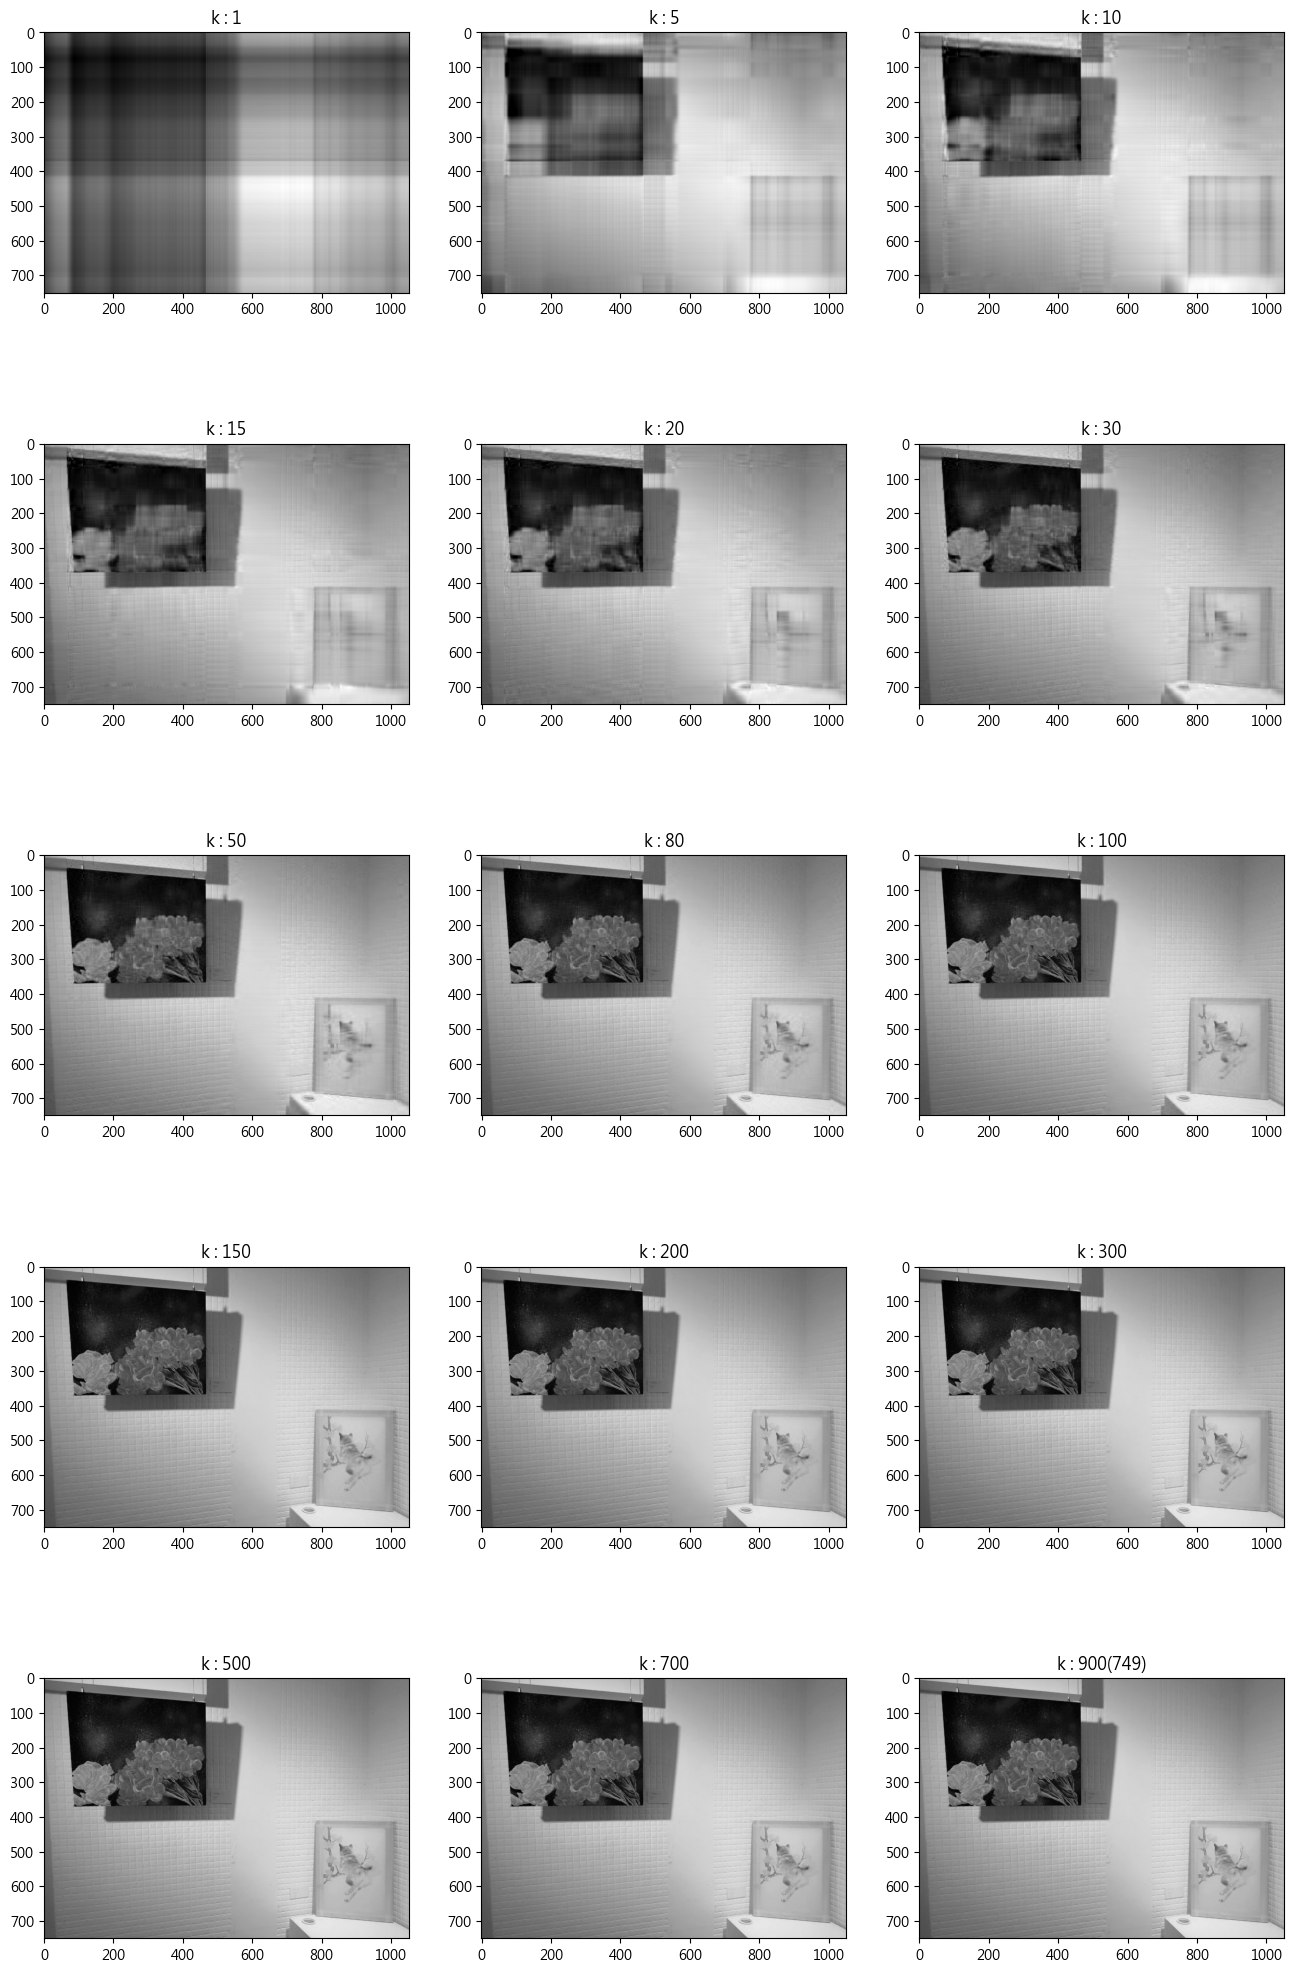

In [175]:

plt.figure(figsize=(16, 24))

p = 0

garyInfoTempTable = np.zeros((15, 3))

for k in rangeArrK:

    # 灰階圖的SVD分解
    
    G, sigma, norm, sigmak1, m = svd_restore(painting_gray, k, "灰階")

    garyInfoTempTable[p,0] = norm
    garyInfoTempTable[p,1] = sigmak1
    garyInfoTempTable[p,2] = m

    # 將壓縮過的圖片存在 svd 文件夾下

    Image.fromarray(G).save("images\\svd\\svd_painting_gr_" + str(k) + ".jpg")

    # 透過 plt 顯示出來

    p += 1
    plt.subplot(5,3,p)

    sigmaLen = len(sigma)-1
    title = "k : " + str(k) + "(" + str(sigmaLen) + ")" if k > len(sigma)-1 else "k : " + str(k)

    plt.title(title)
    plt.imshow(G, cmap="gray")

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.show()

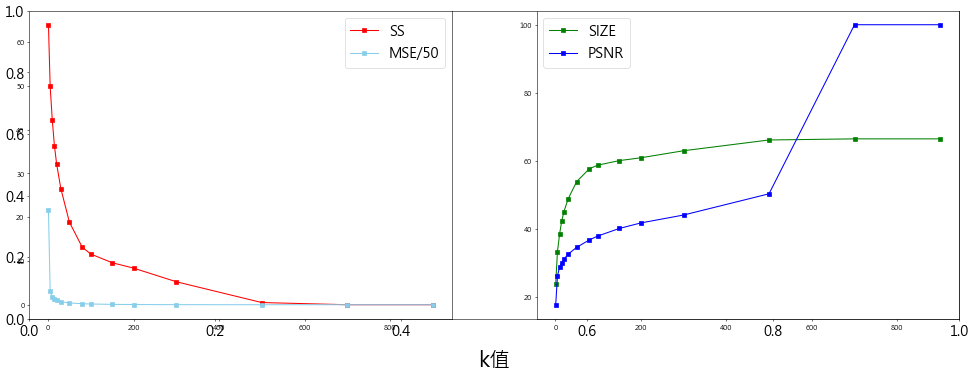

K值        2-norm     sigma k+1  原圖大小(Kb)  圖片大小(Kb)  資料壓縮比(CR)  \
0     1.0  22926.477078  22926.477078     66.49     23.96   2.775042   
1     5.0   4095.693144   4095.693144     66.49     33.32   1.995498   
2    10.0   2100.481006   2100.481006     66.49     38.48   1.727911   
3    15.0   1637.294495   1637.294495     66.49     42.36   1.569641   
4    20.0   1325.064858   1325.064858     66.49     45.05   1.475916   
5    30.0    862.962665    862.962665     66.49     48.86   1.360827   
6    50.0    591.416801    591.416801     66.49     53.94   1.232666   
7    80.0    391.289453    391.289453     66.49     57.75   1.151342   
8   100.0    319.747987    319.747987     66.49     58.79   1.130975   
9   150.0    205.270033    205.270033     66.49     60.11   1.106139   
10  200.0    141.368870    141.368870     66.49     60.93   1.091252   
11  300.0     76.025652     76.025652     66.49     63.00   1.055397   
12  500.0     25.306553     25.306553     66.49     66.16   1.004988   
13  700.0      6.472896      6.472896     66.49     66.49   1.000000   
14  900.0      3.467955      3.467955     66.49     66.49   1.000000   

    節省空間比率(SS)    均方誤差(MSE)  峰值訊噪比(PSNR)  
0    63.964506  1080.105396    17.791865  
1    49.887201   153.990523    26.233966  
2    42.126636    85.597705    28.755049  
3    36.291172    62.475089    30.097234  
4    32.245450    48.948148    31.125980  
5    26.515265    33.990785    32.633434  
6    18.875019    20.585858    34.642404  
7    13.144834    11.480987    36.841282  
8    11.580689     8.234597    37.987154  
9     9.595428     3.991724    40.191059  
10    8.362160     2.092902    41.801713  
11    5.248910     0.657988    44.124724  
12    0.496315     0.060028    50.358741  
13    0.000000     0.001701   100.000000  
14    0.000000     0.000015   100.000000

In [176]:
garyResult = showTable(rangeArrK, garyInfoTempTable, "painting_gr")
showLinear(garyResult, 50)
pd.DataFrame(garyResult, columns=feature_names)

In [177]:
interact(compress_show_gray_images,k=(1,1000))

interactive(children=(IntSlider(value=500, description='k', max=1000, min=1), Output()), _dom_classes=('widget…

<function __main__.compress_show_gray_images(k)>

In [178]:
# 依照不同k值對彩色圖片進行壓縮 

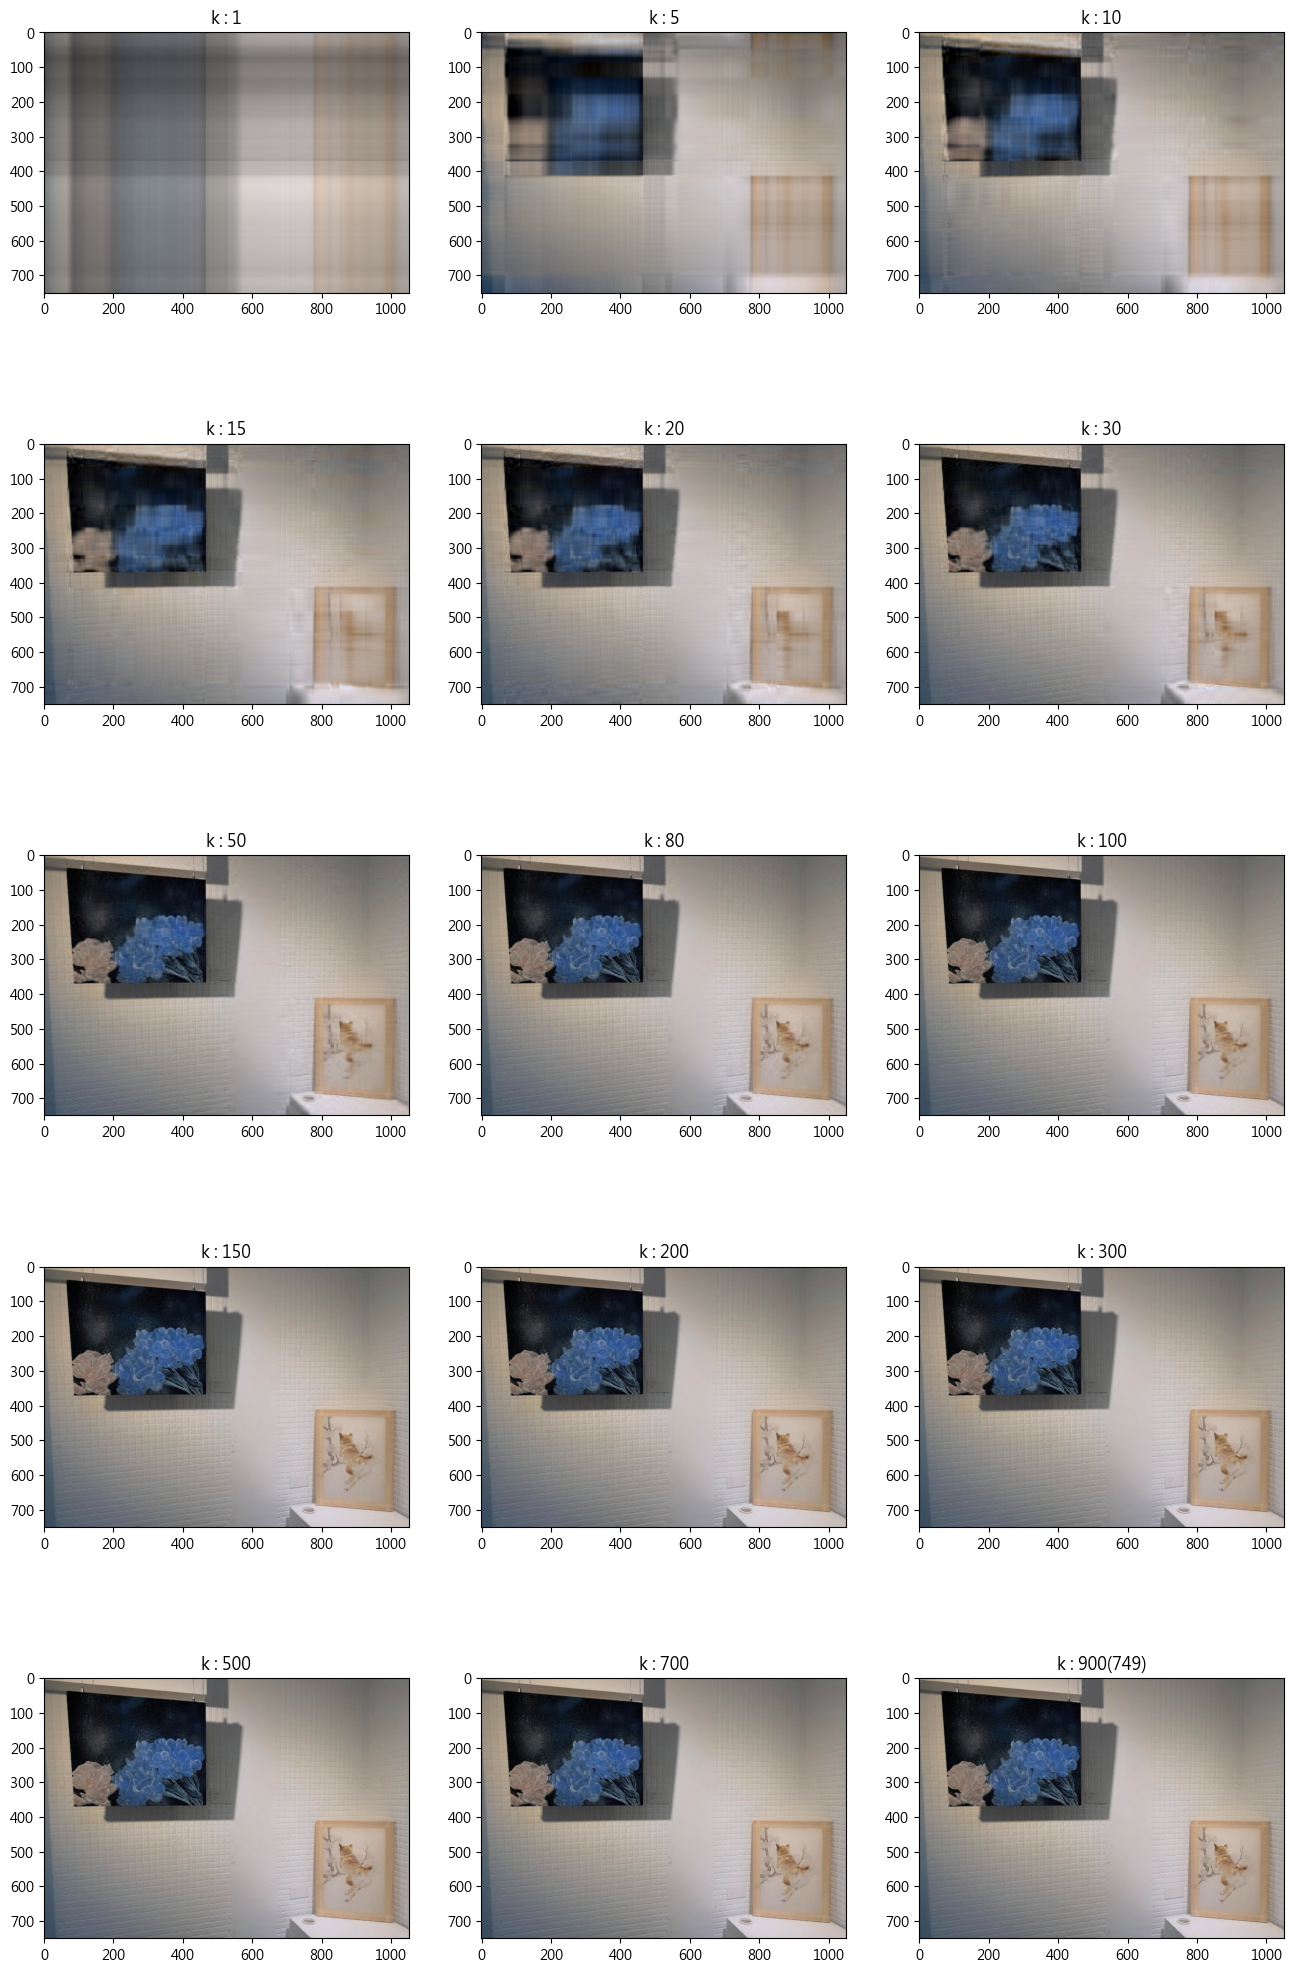

In [179]:
## 1. Reshape method > 先將三維變二維，二維做完svd，再變回三維 > 彩色圖片(橫)

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 設定字型（避免中文字亂碼＆Taipei Sans 警告）
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']   # 微軟正黑體
plt.rcParams['axes.unicode_minus'] = False                 # 避免負號亂碼

plt.figure(figsize=(16, 24))

p = 0

infoTempTable = np.zeros((15, 3))

for k in rangeArrK:

    # Reshape method
    
    original_shape = painting.shape
    image_reshaped = painting.reshape((original_shape[0], original_shape[1] * original_shape[2]))
    image_reconst, sigma, norm, sigmak1, m = svd_restore(image_reshaped, k, "灰階")
    image_reconst = image_reconst.reshape(original_shape)

    infoTempTable[p,0] = norm
    infoTempTable[p,1] = sigmak1
    infoTempTable[p,2] = m

    # 將壓縮過的圖片存在 svd 文件夾下
    Image.fromarray(image_reconst).save("images\\svd\\svd_painting_" + str(k) + ".jpg")

    # 透過 plt 顯示出來
    p += 1
    plt.subplot(5, 3, p)

    sigmaLen = len(sigma)-1
    title = "k : " + str(k) + "(" + str(sigmaLen) + ")" if k > len(sigma)-1 else "k : " + str(k)

    plt.title(title)
    plt.imshow(image_reconst)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.show()

In [180]:
rgbResult = showTable(rangeArrK, infoTempTable, "painting")
showLinear(rgbResult, 30)
pd.DataFrame(rgbResult, columns=feature_names)

K值        2-norm     sigma k+1  原圖大小(Kb)  圖片大小(Kb)  資料壓縮比(CR)  \
0     1.0  38709.663565  38709.663565    312.65     28.54  10.954800   
1     5.0   7723.022376   7723.022376    312.65     38.79   8.060067   
2    10.0   3822.638269   3822.638269    312.65     43.91   7.120246   
3    15.0   2953.576787   2953.576787    312.65     47.37   6.600169   
4    20.0   2309.912794   2309.912794    312.65     50.18   6.230570   
5    30.0   1563.640503   1563.640503    312.65     53.76   5.815662   
6    50.0   1050.036865   1050.036865    312.65     58.88   5.309952   
7    80.0    711.545770    711.545770    312.65     63.18   4.948560   
8   100.0    567.535930    567.535930    312.65     64.40   4.854814   
9   150.0    368.630291    368.630291    312.65     65.84   4.748633   
10  200.0    258.563938    258.563938    312.65     66.87   4.675490   
11  300.0    140.195454    140.195454    312.65     68.89   4.538395   
12  500.0     49.855144     49.855144    312.65     72.11   4.335737   
13  700.0     17.259627     17.259627    312.65     72.58   4.307661   
14  900.0     11.601686     11.601686    312.65     72.59   4.307067   

    節省空間比率(SS)    均方誤差(MSE)  峰值訊噪比(PSNR)  
0    90.871582  1083.994748    17.773172  
1    87.593155   173.025036    25.731577  
2    85.955541    94.566862    28.322695  
3    84.848873    68.443657    29.714963  
4    83.950104    53.329719    30.766805  
5    82.805054    36.460756    32.341963  
6    81.167440    22.111191    34.323719  
7    79.792100    12.445497    36.430235  
8    79.401887     8.962380    37.502039  
9    78.941308     4.438405    39.360611  
10   78.611866     2.383453    40.415395  
11   77.965776     0.792665    41.135345  
12   76.935871     0.092502    41.337614  
13   76.785543     0.004735    41.352374  
14   76.782344     0.000057    41.352297

In [181]:
interact(compress_show_color_images_reshape,k=(1,1000))

interactive(children=(IntSlider(value=500, description='k', max=1000, min=1), Output()), _dom_classes=('widget…

<function __main__.compress_show_color_images_reshape(k)>

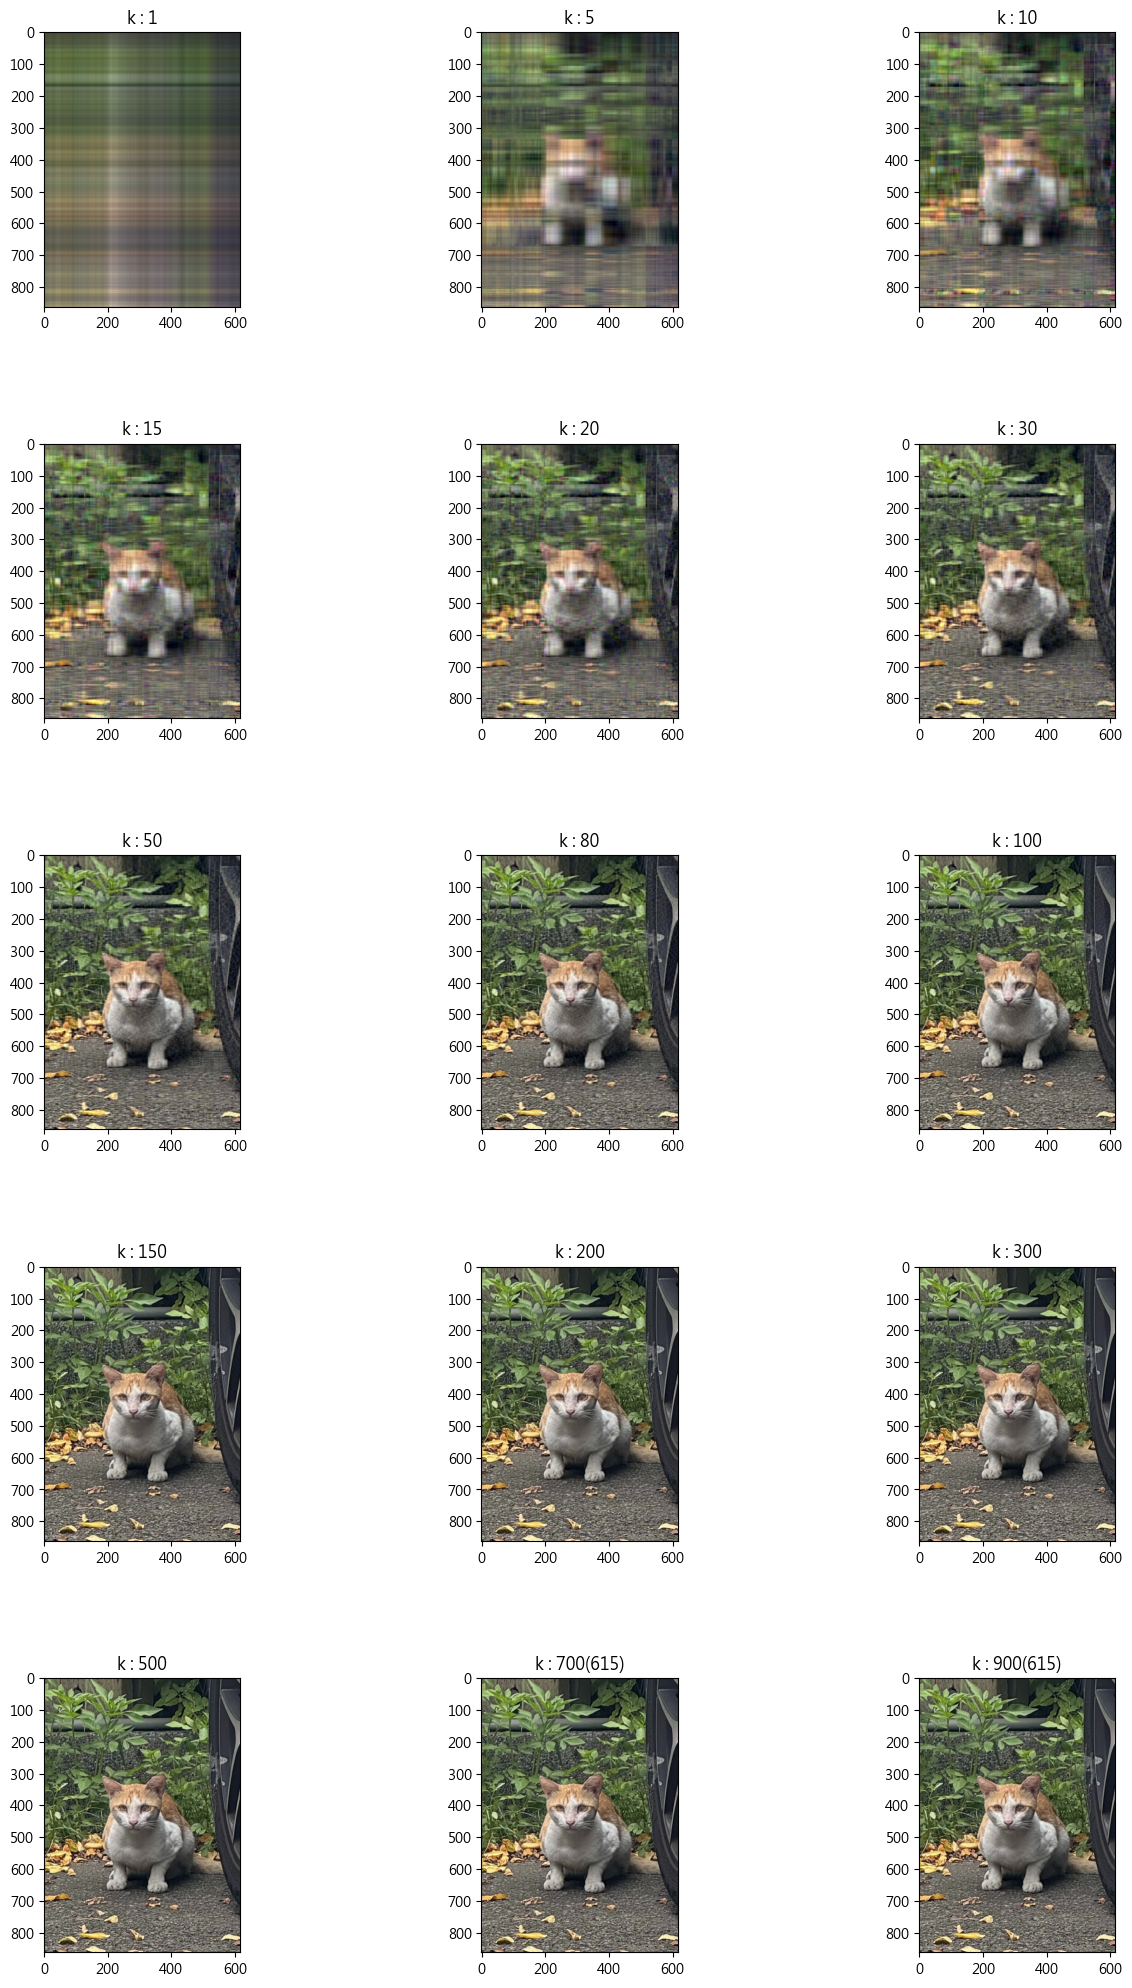

In [182]:
## 2. Layers method > 分別對二維的R圖、G圖、B圖各自做svd，再把三張圖合起來 > 彩色圖片(直)
plt.figure(figsize=(16,24))

p = 0

verInfoTempTable = np.zeros((15, 3))

for k in rangeArrK:

    # R的SVD分解
    R, sigma, normR, sigmak1R, mR = svd_restore(cat_ver[:, :, 0], k, "R")

    # G的SVD分解  
    G, sigma, normG, sigmak1G, mG = svd_restore(cat_ver[:, :, 1], k, "G")

    # B的SVD分解     
    B, sigma, normB, sigmak1B, mB = svd_restore(cat_ver[:, :, 2], k, "B")

    verInfoTempTable[p,0] = (normR+normG+normB)/3
    verInfoTempTable[p,1] = (sigmak1R+sigmak1G+sigmak1B)/3
    verInfoTempTable[p,2] = (mR+mG+mB)/3

    # 壓縮後的 RGB 組合一張圖    
    I = np.dstack((R, G, B))

    # 將壓縮過的圖片存在 svd 文件夾下
    Image.fromarray(I).save("images\\svd\\svd_schoolCat_" + str(k) + ".jpg")

    # 透過 plt 顯示出來
    p += 1
    plt.subplot(5,3,p)

    sigmaLen = len(sigma)-1
    title = "k : " + str(k) + "(" + str(sigmaLen) + ")" if k > len(sigma)-1 else "k : " + str(k)
    
    plt.title(title)
    plt.imshow(I)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.show()

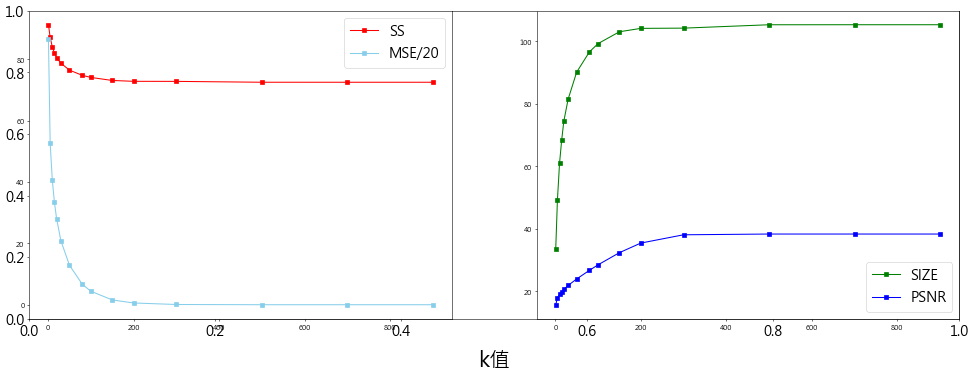

K值        2-norm     sigma k+1  原圖大小(Kb)  圖片大小(Kb)  資料壓縮比(CR)  \
0     1.0  12591.942717  12591.942717     382.9     33.51  11.426440   
1     5.0   5714.687176   5714.687176     382.9     49.30   7.766734   
2    10.0   4221.219760   4221.219760     382.9     61.09   6.267802   
3    15.0   3535.612835   3535.612835     382.9     68.50   5.589781   
4    20.0   3082.916546   3082.916546     382.9     74.49   5.140287   
5    30.0   2413.916695   2413.916695     382.9     81.47   4.699890   
6    50.0   1759.031494   1759.031494     382.9     90.14   4.247837   
7    80.0   1214.745551   1214.745551     382.9     96.64   3.962127   
8   100.0    989.073091    989.073091     382.9     99.25   3.857935   
9   150.0    579.329898    579.329898     382.9    103.05   3.715672   
10  200.0    348.760967    348.760967     382.9    104.13   3.677134   
11  300.0    127.947899    127.947899     382.9    104.21   3.674311   
12  500.0     15.435801     15.435801     382.9    105.29   3.636623   
13  700.0      4.370496      4.370496     382.9    105.30   3.636277   
14  900.0      4.370496      4.370496     382.9    105.30   3.636277   

    節省空間比率(SS)    均方誤差(MSE)  峰值訊噪比(PSNR)  
0    91.248368  1730.686238    15.744406  
1    87.124576  1053.929188    17.894110  
2    84.045443   812.713609    19.037832  
3    82.110212   667.682709    19.890135  
4    80.545834   561.842335    20.644577  
5    78.722904   418.069858    21.912221  
6    76.458605   258.174272    23.982113  
7    74.761034   133.988131    26.758849  
8    74.079394    88.158286    28.499625  
9    73.086968    31.443980    32.390485  
10   72.804910    11.400985    35.463068  
11   72.784017     1.486223    38.111267  
12   72.501959     0.023735    38.352051  
13   72.499347     0.000036    38.350832  
14   72.499347     0.000036    38.350832

In [183]:
verResult = showTable(rangeArrK, verInfoTempTable, "schoolCat")
showLinear(verResult, 20)
pd.DataFrame(verResult, columns=feature_names)

In [184]:
interact(compress_show_color_images_layer,k=(1,1000))

interactive(children=(IntSlider(value=500, description='k', max=1000, min=1), Output()), _dom_classes=('widget…

<function __main__.compress_show_color_images_layer(k)>